# Парсинг hh.ru

### Сборка данных

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid")

import numpy as np  # математические операции и пр.
import tqdm         # для дальнейшего импорта прогресс-бара
import time         # для обычных пауз
import re


from selenium import webdriver # импорт драйвера
from selenium.webdriver.chrome.service import Service # импортируем сущность Service
from webdriver_manager.chrome import ChromeDriverManager # импорт драйвера для Google Chrome
from selenium.webdriver.common.by import By # поиск по локаторам
from selenium.webdriver.common.keys import Keys # отправление ключей
from selenium.webdriver.chrome.options import Options 
from selenium.webdriver.common.by import By

from env import mail_email, hhru_password
import requests
from bs4 import BeautifulSoup

### Сбор html страниц

In [170]:
def grap_htmls(vacancy_name:str, region:str):
    """
    input - vacancy_name str, seeking job
            region str, neeeded region of Russi
    output - soup_list list containing htmls of parsed hh-ru data
    """
    options = Options()
    options.add_argument("start-maximized") 
    wb = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    link = "https://kazan.hh.ru/account/login?backurl=%2Fapplicant%2Fresumes%2Fnew"
    wb.get(link)

    by_password = wb.find_element(By.CLASS_NAME, "bloko-link_disable-visited")
    by_password.click()
    
    email_field = wb.find_element(By.XPATH, '//*[@id="HH-React-Root"]/div/div/div[1]/div[4]/div[1]/div/div/div/div/div/div[1]/div/div/form/div[1]/fieldset/input')
    email_field.send_keys(mail_email)
    
    password_field =  wb.find_element(By.XPATH, '//*[@id="HH-React-Root"]/div/div/div[1]/div[4]/div[1]/div/div/div/div/div/div[1]/div/div/form/div[2]/fieldset/input' )
    password_field.send_keys(hhru_password)
    
    log_in_button =  wb.find_element(By.XPATH, '//*[@id="HH-React-Root"]/div/div/div[1]/div[4]/div[1]/div/div/div/div/div/div[1]/div/div/form/div[6]/button[1]' )
    log_in_button.click()
    
    time.sleep(3)
    
    search_button  =  wb.find_element(By.XPATH, '//*[@id="HH-React-Root"]/div/div/div[3]/div[1]/div/div/div/div[5]/span/button' )
    search_button.click()
    
    expand_search = wb.find_element(By.XPATH,  '//*[@id="supernova_search_form"]/div/div[3]/a')
    expand_search.click()   
    
    
    time.sleep(4)
    
    wb.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    remove_current_location = wb.find_element(By.XPATH, '//*[@id="HH-React-Root"]/div/div/div[4]/div[1]/div/div/div[1]/form/div[9]/div[3]/div/div/div/div/button')
    remove_current_location.click()
    
    region = ''
    input_region = wb.find_element(By.XPATH, '//*[@id="HH-React-Root"]/div/div/div[4]/div[1]/div/div/div[1]/form/div[9]/div[3]/div/div/fieldset/input')
    input_region.send_keys(region)
    
    vacancy_search_line = wb.find_element(By.XPATH,  '//*[@id="HH-React-Root"]/div/div/div[4]/div[1]/div/div/div[1]/form/div[1]/div[3]/div[1]/fieldset/input')
    vacancy_search_line.send_keys(vacancy_name)
    vacancy_search_line.send_keys(Keys.ENTER)
    
    
    wb.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5)
            

    html = wb.page_source
    first_page = BeautifulSoup(html)
    
    soup_list = []
    for i in range(2, 50):
        try:
            wb.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(6)
            button_xpath = '//*[@id="HH-React-Root"]/div/div/div[1]/div[4]/div[1]/div[1]/div[3]/div[2]/div[1]/div/main/div[5]/div[1]/a'
            switch_page = wb.find_element(By.XPATH, button_xpath)
            switch_page.click()
    
            time.sleep(2)
    
            html = wb.page_source

            soup_list.append(BeautifulSoup(html) )
            
        except:
            print('Failed to parse page {}'.format(i))
    
    soup_list.insert(0, first_page)
    return soup_list
    

In [3]:
%%time
soup_list = grap_htmls('Аналитик', '')

Failed to parse page 18
Failed to parse page 25
Failed to parse page 27
Failed to parse page 30
Failed to parse page 32
Failed to parse page 35
Failed to parse page 37
Failed to parse page 39
Failed to parse page 41
Failed to parse page 43
Failed to parse page 45
Failed to parse page 47
CPU times: total: 8.58 s
Wall time: 9min 13s


### Преобразование в data.frame

In [156]:
def parse_htmls(soup_list):
    final_df = pd.DataFrame()
    iterator = 1
    for page in soup_list:
        try:
            vacancies = page.find_all("span",  {'data-qa' : "serp-item__title"})
            companies = page.find_all('span', {'class': 'company-info-text--O32pGCRW0YDmp3BHuNOP'}) 
            experiences = page.find_all('span', {'data-qa': 'vacancy-serp__vacancy-work-experience'})[1::2]
            responsibilities = page.find_all('div', {'data-qa': 'vacancy-serp__vacancy_snippet_responsibility'})
            df = {
            'vacancy_title' : [i.text for i in vacancies],
            'company' : [i.text for i in companies],
            'experience' : [i.text for i in experiences],
            'responsibilities': [i.text for i in responsibilities]
        }
            df = pd.DataFrame(df)
            final_df = pd.concat([final_df, df],  ignore_index=True)
        except:
            print("Page number {}".format(iterator))
            iterator +=1
    return final_df
        
        
        
        

In [210]:
%%time
df = parse_htmls(soup_list)

Page number 1
Page number 2
Page number 3
Page number 4
Page number 5
Page number 6
Page number 7
Page number 8
Page number 9
CPU times: total: 2.98 s
Wall time: 2.99 s


In [152]:
df.to_excel('parsed.xlsx')

### Аналитика

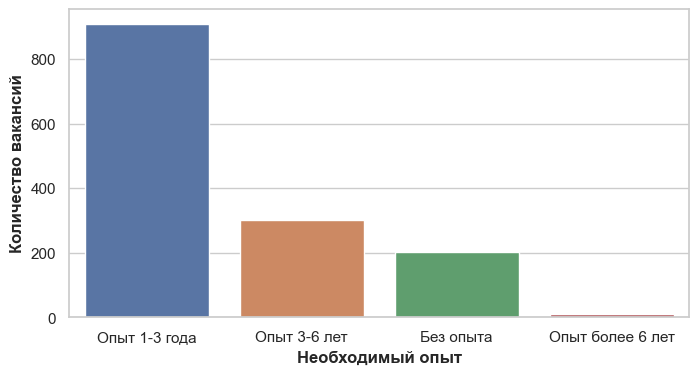

In [215]:
fig, ax = plt.subplots(figsize=(8, 4));
sns.countplot(data = df, x = 'experience', order=df['experience'].value_counts().index , ax = ax);
plt.xlabel('Необходимый опыт',  fontsize=12, fontweight="bold");
plt.ylabel('Количество вакансий',  fontsize=12, fontweight="bold");

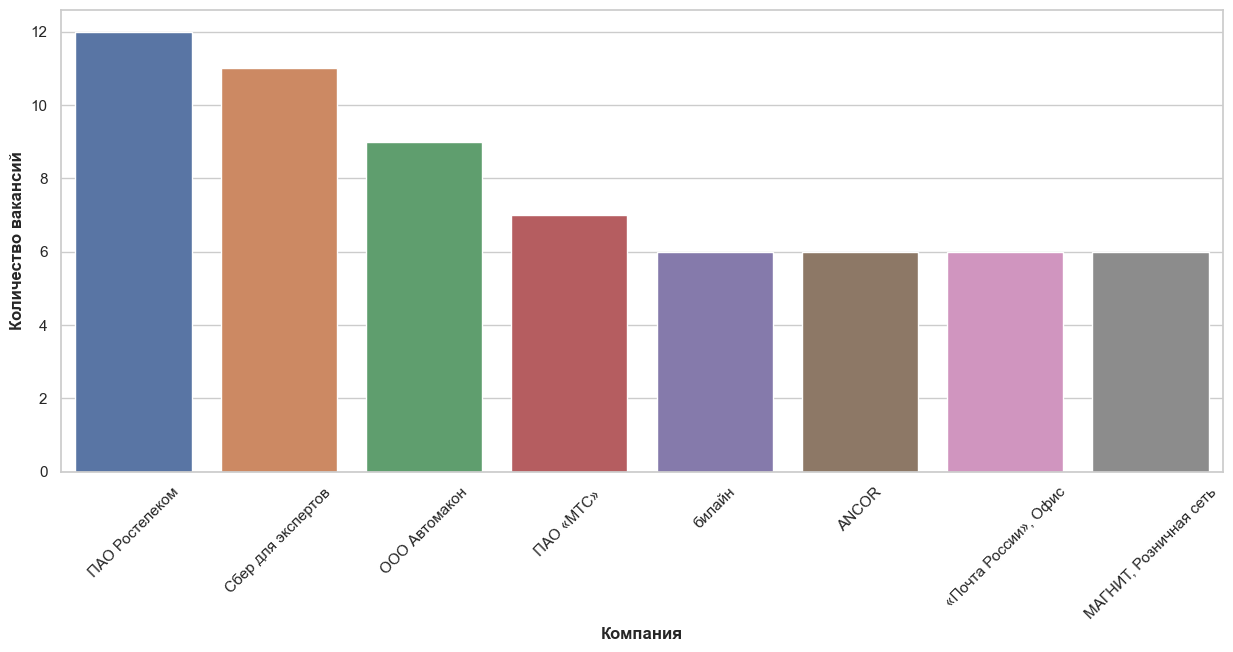

In [220]:
count_by_company = df.groupby('company').size().reset_index(name='counts')

# Filter categories with frequency greater than 10
filtered_categories = count_by_company[count_by_company['counts'] > 5]['company']

# Filter the original DataFrame
filtered_df = df[df['company'].isin(filtered_categories)]

fig, ax = plt.subplots(figsize=(15, 6));
sns.countplot(data = filtered_df, x = 'company',
              order = filtered_df['company'].value_counts().index, ax = ax
             );
plt.xticks(rotation=45);
plt.xlabel('Компания',  fontsize=12, fontweight="bold");
plt.ylabel('Количество вакансий',  fontsize=12, fontweight="bold");

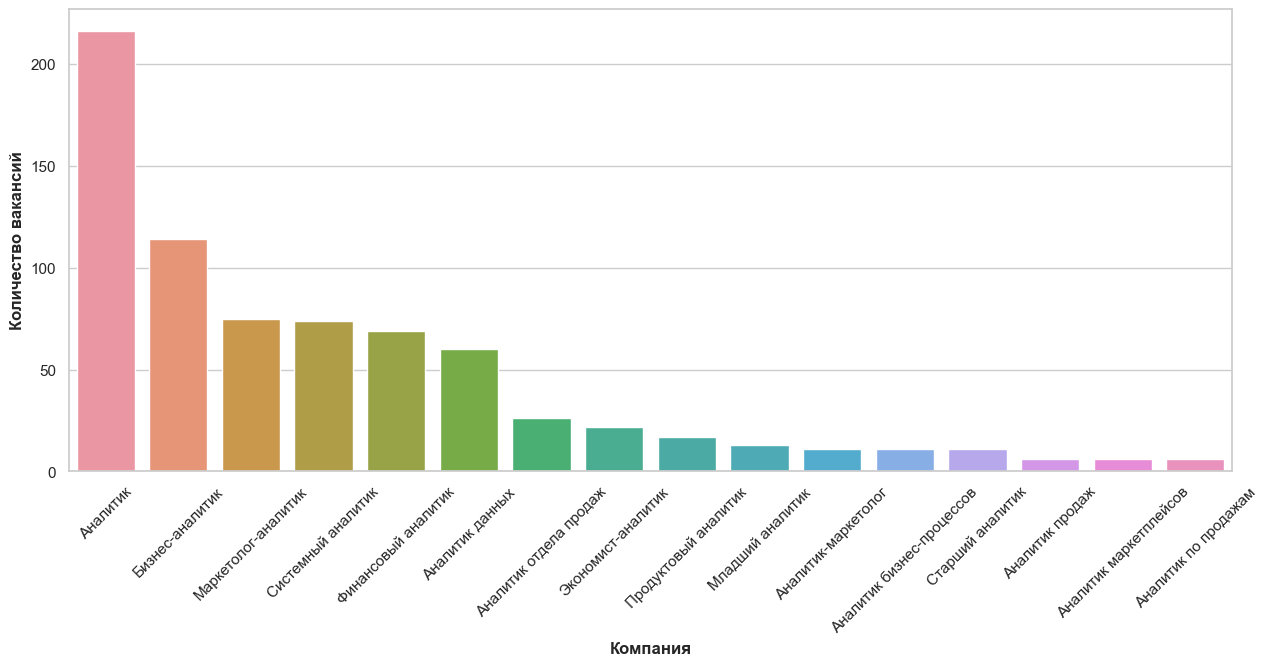

In [222]:
count_by_vacancy_title = df.groupby('vacancy_title').size().reset_index(name='counts')

# Filter categories with frequency greater than 10
filtered_categories = count_by_vacancy_title[count_by_vacancy_title['counts'] > 5]['vacancy_title']

# Filter the original DataFrame
filtered_df = df[df['vacancy_title'].isin(filtered_categories)]
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data = filtered_df, x = 'vacancy_title',  
              order = filtered_df['vacancy_title'].value_counts().index, ax = ax
             )
plt.xticks(rotation=45);
plt.xlabel('Компания',  fontsize=12, fontweight="bold");
plt.ylabel('Количество вакансий',  fontsize=12, fontweight="bold");